
0: 416x640 1 Plaka, 54.6ms
Speed: 1.6ms preprocess, 54.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 1 3, 1 4, 1 5, 1 7, 1 U, 64.0ms
Speed: 3.1ms preprocess, 64.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)
Biển số phát hiện: 75U34


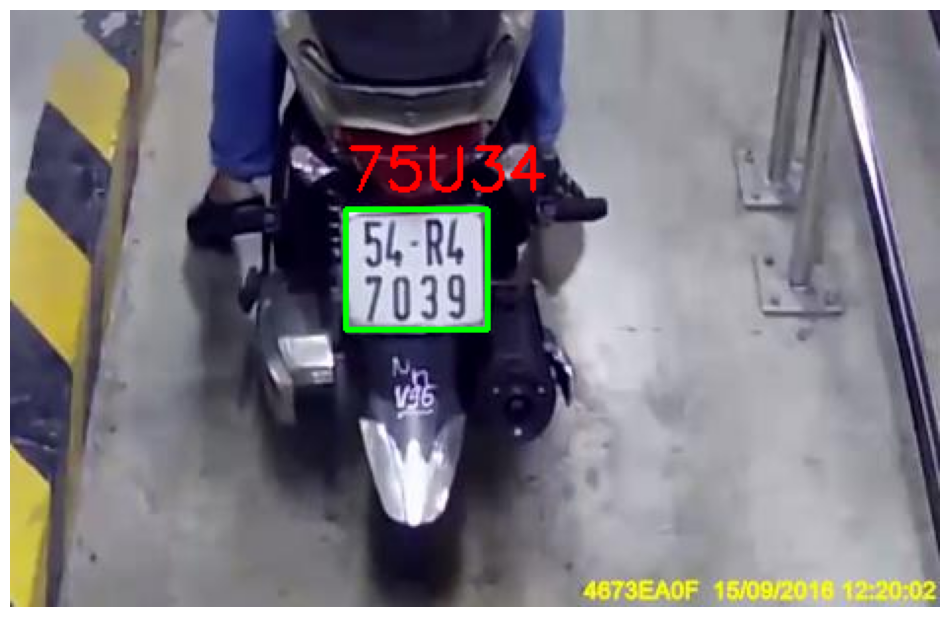

In [17]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Tải mô hình nhận diện vùng biển số
plate_model = YOLO("runs/weights/best.pt")  # mô hình phát hiện biển số
char_model = YOLO("detectchar/weights/best.pt")    # mô hình phát hiện từng ký tự

# Load ảnh gốc
image_path = "GreenParking/GreenParking/0520_06287_b.jpg"
image = cv2.imread(image_path)
assert image is not None, "Không đọc được ảnh gốc!"

# Bước 1: Dò vùng chứa biển số
plate_results = plate_model(image)
plate_boxes = plate_results[0].boxes.xyxy.cpu().numpy()

def preprocess_plate(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)          # chuyển sang grayscale
    gray = cv2.equalizeHist(gray)                         # cân bằng histogram
    blur = cv2.GaussianBlur(gray, (3, 3), 0)              # làm mịn nhẹ để khử nhiễu
    sharpen_kernel = np.array([[0, -1, 0],
                                [-1, 5,-1],
                                [0, -1, 0]])               # kernel làm nét
    sharpened = cv2.filter2D(blur, -1, sharpen_kernel)
    return cv2.cvtColor(sharpened, cv2.COLOR_GRAY2BGR)     # convert lại 3 kênh


# Bước 2: Với mỗi vùng biển số được phát hiện, crop và chạy nhận diện ký tự
for plate_box in plate_boxes:
    x1, y1, x2, y2 = map(int, plate_box)
    cropped_plate = image[y1:y2, x1:x2]

    # ⬇️ Xử lý ảnh trước khi cho nhận diện ký tự
    processed_plate = preprocess_plate(cropped_plate)

    # Bước 3: Dò từng ký tự bằng mô hình char_model
    char_results = char_model(processed_plate)[0]
    chars = []

    for box in char_results.boxes:
        cls_id = int(box.cls.cpu().item())
        cls_name = char_model.names[cls_id]  # tên ký tự, ví dụ 'A', '1', v.v.
        x_min, _, x_max, _ = map(int, box.xyxy[0].cpu().numpy())
        center_x = (x_min + x_max) / 2
        chars.append((center_x, cls_name))

    # Sắp xếp ký tự theo tọa độ x (từ trái qua phải)
    chars.sort(key=lambda x: x[0])
    plate_text = ''.join([char for _, char in chars])

    # Vẽ bounding box và gắn chuỗi biển số
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, plate_text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    print(f"Biển số phát hiện: {plate_text}")


# Hiển thị ảnh kết quả
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()


In [18]:
print(char_model.names)



{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L', 20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}
